In [ ]:
################################################################################################################
################################################## INSTALL MODULES #############################################
################################################################################################################

!pip install click | grep -v 'already satisfied'
!pip install numpy | grep -v 'already satisfied'
!pip install requests | grep -v 'already satisfied'
!pip install Pillow | grep -v 'already satisfied'
!pip install torch torchvision torchaudio | grep -v 'already satisfied'
!pip install pandas | grep -v 'already satisfied'
!pip install scipy | grep -v 'already satisfied'
!pip install lpips | grep -v 'already satisfied'
print("All dependencies installed")


In [14]:
################################################################################################################
################################################### IMPORT MODULES #############################################
################################################################################################################

import os
import re
import pandas as pd
from typing import List, Optional, Tuple, Union
from io import BytesIO
import torch.nn.functional as F



import click
import dnnlib
import numpy as np
import PIL.Image
import torch
import lpips
import torch.nn as nn


import legacy
from stablehash_dataset import StableHashDataset
from torch.utils.data import DataLoader

print("All modules imported")

All modules imported


In [20]:
################################################################################################################
############################################# SET ENVIRONMENT VARIABLES ########################################
################################################################################################################

# Set Nvidia Network model 
network_pkl = "/home/ubuntu/nvidia-model/stylegan3-r-ffhq-1024x1024.pkl"

# Load training dataset and create iterator
data_dir = "/volumes/1/output/"

stablehash_mapping_csv = "/home/ubuntu/stablehash-reconstruct/training_data-70percent0-19.csv" # 70% OF CLUSTERS
#stablehash_mapping_csv = "/home/ubuntu/stablehash-reconstruct/training_data-100percent.csv" # 100% OF CLUSTERS
#stablehash_mapping_csv = "/home/ubuntu/stablehash-reconstruct/training_data-cluster10-unique-id.csv" # Single cluster with unique IDs



#### Only for testing: Reduce to single cluster with unique IDs
#df = pd.read_csv(stablehash_mapping_csv, sep = ";")
#df = df[df['stablehash_dir'] == '/home/ubuntu/trainingfiles/frgc_centers_converted/frgc_cluster_10.npy']
#df["subject_id"] = df["img_dir"].str.extract(r"/(\d+)d")
#df.drop_duplicates(subset=["subject_id"], keep="first", inplace=True)
#df.drop(columns=["subject_id"], inplace=True)
#df.to_csv("/home/ubuntu/stablehash-reconstruct/training_data-cluster10-unique-id.csv", index=False, sep = ";")
#stablehash_mapping_csv = "/home/ubuntu/stablehash-reconstruct/training_data-cluster10-unique-id.csv"
#######



percent = "70" # MODEL TRAINED ON 70% OF CLUSTERS (0-44)
#percent = "100" # MODEL TRAINED ON 100% OF CLUSTERS (0-63)
model_name = f"trained_model_{percent}%.pt" 

loss = 0.119
stablehash_predict = "/home/ubuntu/stablehash-reconstruct/training_data-100percent.csv"

seeds = list(range(63))
truncation_psi = 0.7
noise_mode = "const"
translate = 0,0
rotate = 0
class_idx = None
gradient_accumulation_steps = 10

train_data = StableHashDataset(data_dir, stablehash_mapping_csv)
train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
#stablehash, original_img = next(iter(train_dataloader))

print("All variables set")

All variables set


In [22]:
################################################################################################################
######################################### VERIFY THAT ALL IMAGE FILES EXIST ####################################
################################################################################################################

with open(stablehash_mapping_csv, "r") as f:
    print("")
    next(f)
    count = 0
    for line in f:
        image_count = line.strip().split(";")[0]
        if not os.path.isfile(image_count):
            print(f"File {image_count} does not exist")
        count += 1
        
print("Scanned",count,"files")


Scanned 79 files


In [23]:
################################################################################################################
#################################################### RUN SCRIPT ################################################
################################################################################################################

def generate_model():
    
    # 1) Load pre-trained Generator
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    print("Network loaded")
    
    # 2) Define mapping and synthesis network (freeze)
    #mapping_n = G.mapping
    #synthesis_n = G.synthesis
    for mapping_param in G.mapping.parameters(): # set mapping network params to trainable
        mapping_param.requires_grad = True
    for synthesis_param in G.synthesis.parameters(): # set synthesis params to frozen
        synthesis_param.requires_grad = False
    print("Defined boolean mapping")
    
    # 3) Define optimizer --> in this case we use ADAM
    optim = torch.optim.Adam(G.mapping.parameters(), lr=0.1, betas=[0,0.99], eps=1e-8)
    print("Optimizer defined")
    
    torch.cuda.empty_cache()
    
    # 4) Define simple MSE loss function
    mse_loss_value_type = torch.nn.MSELoss(reduction="mean")
    
    loss_value_type = lpips.LPIPS(net='alex').to(device) # NOTE: Alternative loss function to test
    loss_value = loss + 00.1
    count = 0
    while loss_value > loss:
        count += 1
        stablehash, orig_img = next(iter(train_dataloader))
        
        # Resize the image
        orig_img = F.interpolate(orig_img, size=128, mode='bilinear', align_corners=False)
    
        w = G.mapping(stablehash, class_idx) #torch.flip(stablehash, [1]), class_idx) # remove flip function --> only for testing
        gen_img = G.synthesis(w)
        gen_img = F.interpolate(gen_img, size=128, mode='bilinear', align_corners=False)

        # NOTE: neural networks should always train between [-1, 1]
        # Therefore, we rescale the original img from [0, 255] to [-1, 1] only for training
        #gen_img = (gen_img * 127.5 + 128).clamp(0, 255).float() 
        orig_img = (orig_img / 127.5 - 1).float()
        loss_value = torch.mean(loss_value_type(gen_img, orig_img)) #+ mse_loss_value_type(gen_img, orig_img)
        loss_value.backward()
        if (count+1) % gradient_accumulation_steps == 0:
            optim.step() #gradient descent
            optim.zero_grad()
            print(loss_value.item())
        
    if loss_value != loss_value:
        print("we failed. Count:")
        print(count)
        print(loss_value)
        sys.exit('Program exiting due to error')
        #z = np.random.RandomState(seed).randn(1, G.z_dim)
        # np.save(os.path.join(data_dir, f"{model_name}"), z)
        #z = torch.from_numpy(z).to(device)
        #w = G.mapping(z, class_idx)
        
    torch.save(G.state_dict(), f'{data_dir}{model_name}')
    #np.save(f'{data_dir}{model_name}', gen_img.detach().cpu().numpy())
    print("Exported trained model to file" f'{data_dir}{model_name}')
        
    print("Exit")
        
generate_model() 

Loading networks from "/home/ubuntu/nvidia-model/stylegan3-r-ffhq-1024x1024.pkl"...
Network loaded
Defined boolean mapping
Optimizer defined
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/ubuntu/environments/my_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/environments/my_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ubuntu/environments/my_env/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
0.46460261940956116
0.4646957516670227
0.45269346237182617
0.43174847960472107
0.43129196763038635
0.47611480951309204
0.4482712745666504
0.4624265134334564
0.4184010624885559
0.3990109860897064
0.3935723602771759
0.4797544479370117
0.42848071455955505
0.4416514039039612
0.44991007447242737
0.419840544462204
0.4442634582519531
0.39004597067832947
0.36673638224601746
0.416241854429245
0.43964216113090515
0.34169939160346985
0.39399442076683044
0.4101574420928955
0.41517171263694763
0.3618869483470917
0.41178032755851746
0.38511547446250916
0.387855589389801
0.3666873872280121
0.39783012866973877
0.3662468492984772
0.3491886556148529
0.38239189982414246
0.4208345413208008
0.41298577189445496
0.39609524607658386
0.37796518206596375
0.35689496994018555
0.363810271024704
0.35415545105934143
0.3742445707321167
0.3984215259552002
0.33040130138397217
0.4030154347419739
0.385546445846557

In [24]:

# set device and load fine-tuned weight state
device = torch.device('cuda')
state_dict = torch.load(f'{data_dir}{model_name}')

# load G as default
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

# Change default state to finetuned state
G.load_state_dict(state_dict)
    
# set generator to eval mode
G.eval()

# load stablehash dataset
predict_data = StableHashDataset(data_dir, stablehash_predict)
predict_dataloader = DataLoader(predict_data, batch_size=4, shuffle=False)

# generate new images
for i, stablehash in enumerate(predict_dataloader):
    w = G.mapping(stablehash[0], class_idx)
    gen_imgs = G.synthesis(w)
    for j, img in enumerate(gen_imgs):
        print(img.shape)
        # Get cluster name from stablehash_predict 
        with open(stablehash_predict, 'r') as f:
            lines = f.readlines()
            xx = lines[i*4+j+1].split(';')[-1].split('_')[-1].split('.')[0]
        filename = f"{data_dir}frgc_cluster_{xx}.png"
        #if os.path.isfile(filename):
        #    print(f"File {filename} already exists, skipping...")
        #else:
        img = (img.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
        PIL.Image.fromarray(img, 'RGB').save(filename)
        print(f"Saved image {i*4+j} to {filename}")

torch.Size([3, 1024, 1024])
Saved image 0 to /volumes/1/output/frgc_cluster_0.png
torch.Size([3, 1024, 1024])
Saved image 1 to /volumes/1/output/frgc_cluster_1.png
torch.Size([3, 1024, 1024])
Saved image 2 to /volumes/1/output/frgc_cluster_36.png
torch.Size([3, 1024, 1024])
Saved image 3 to /volumes/1/output/frgc_cluster_35.png
torch.Size([3, 1024, 1024])
Saved image 4 to /volumes/1/output/frgc_cluster_63.png
torch.Size([3, 1024, 1024])
Saved image 5 to /volumes/1/output/frgc_cluster_35.png
torch.Size([3, 1024, 1024])
Saved image 6 to /volumes/1/output/frgc_cluster_4.png
torch.Size([3, 1024, 1024])
Saved image 7 to /volumes/1/output/frgc_cluster_27.png
torch.Size([3, 1024, 1024])
Saved image 8 to /volumes/1/output/frgc_cluster_56.png
torch.Size([3, 1024, 1024])
Saved image 9 to /volumes/1/output/frgc_cluster_44.png
torch.Size([3, 1024, 1024])
Saved image 10 to /volumes/1/output/frgc_cluster_46.png
torch.Size([3, 1024, 1024])
Saved image 11 to /volumes/1/output/frgc_cluster_23.png
torch

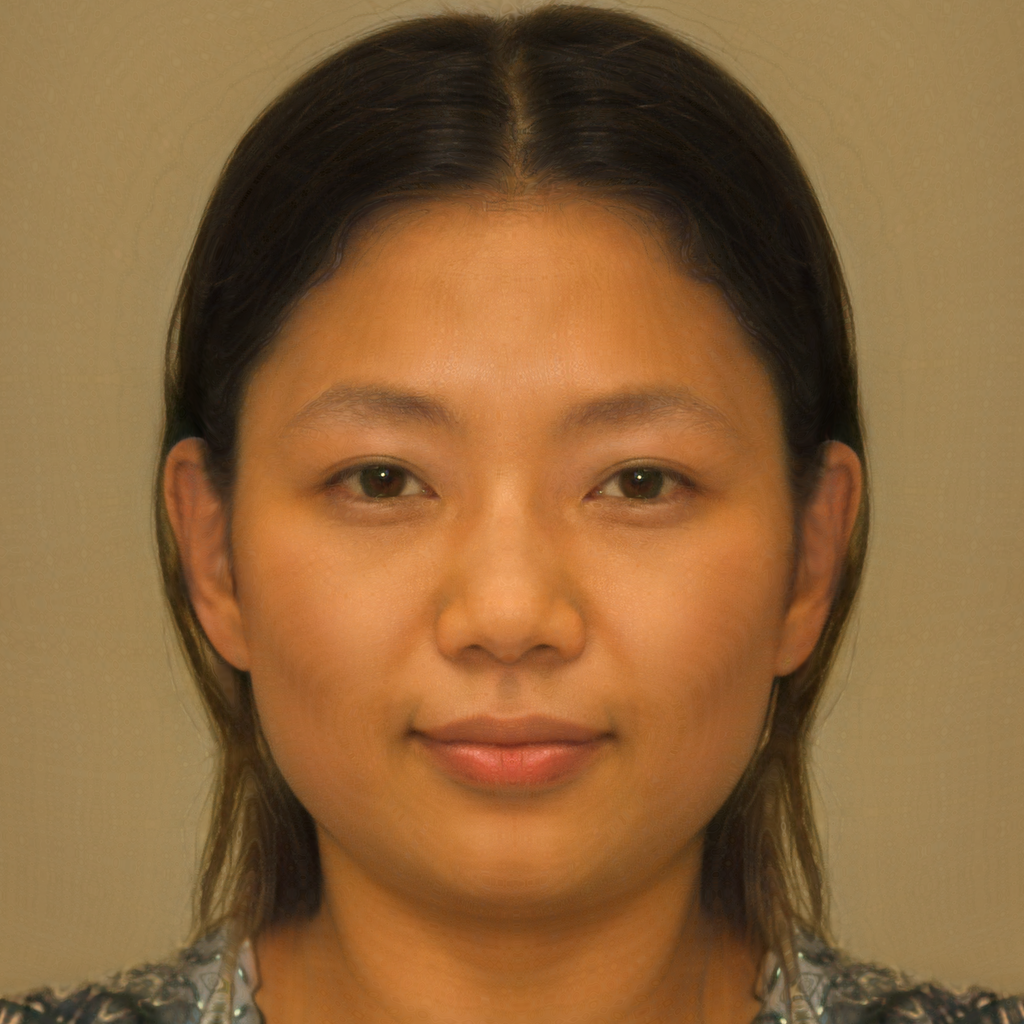

In [6]:
# Show example img
img_path = f"{data_dir}frgc_cluster_10.png"
im = PIL.Image.open(img_path)
im.show()